Removed First row from the PPG-BP dataset xlsx file
Converted new xlsx to CSV for faster execution
New CSV file named as SubjectData.csv
PPGBPDatabase folder contains all the ppg cycle of the subjects in TXT format

In [161]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import skew


## Importing SubjectData CSV file using Pandas

In [162]:
SubjectData=pd.read_csv('SubjectData.csv')
SubjectData.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.27,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.28,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.89,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.97,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.06,Prehypertension,NaN,NaN,NaN


### Data Cleaning
Label encoding - converting the labels into numerical format <br>
Such as <br>
Encoding NaN with 0 in Cerebral Infarction and 'cerebral infarction' as 1 <br>
0 = No Cerebral Infarction <br>
1 = Cerebral Infarction

In [163]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
SubjectData['cerebral infarction']= label_encoder.fit_transform(SubjectData['cerebral infarction'])
SubjectData['Hypertension']= label_encoder.fit_transform(SubjectData['Hypertension'])
SubjectData['Diabetes']= label_encoder.fit_transform(SubjectData['Diabetes'])
SubjectData['cerebrovascular disease']= label_encoder.fit_transform(SubjectData['cerebrovascular disease'])
SubjectData['Sex(M/F)']= label_encoder.fit_transform(SubjectData['Sex(M/F)'])
 
#SubjectData['cerebral infarction'].unique()


In [164]:
countCI=SubjectData['cerebral infarction'].value_counts()
print('Total number of subjects :',countCI[1]+countCI[0])
print('Total number of subjects with CI:',countCI[1])
print('Total number of subjects without CI:',countCI[0])

Total number of subjects : 219
Total number of subjects with CI: 199
Total number of subjects without CI: 20


### Importing PPG Cycle of the Target Patients in a dictionary


In [165]:
baseurl='PPGBPDatabase/'
PPGCycle={}
for i in range(420):
    try:
        temp=[]
        for j in range(1,4):
            f=open(baseurl+f'{i}_{j}.txt','r')
            data=f.readline()
            data=data.split('\t')
            data=data[0:-1]
            data=list(map(int,list(map(float,data))))
            f.close()
            temp.append(data)  
        PPGCycle[str(i)]=temp
    except:
        continue


## Sample Ploting of PPG Cycle of Subject 2

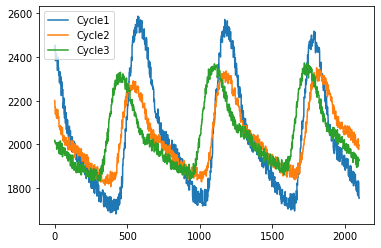

In [166]:
C1=PPGCycle['2'][0]
C2=PPGCycle['2'][1]
C3=PPGCycle['2'][2]
plt.plot(C1,label='Cycle1')
plt.plot(C2,label='Cycle2')
plt.plot(C3,label='Cycle3')
plt.legend(['Cycle1','Cycle2','Cycle3'])
plt.show()

### Extracting Infromation from the PPGCycle

# Functions to calculate Features and values


In [167]:
def Kurt(x):
    size=len(x)
    deviationSq=[]
    deviationSq4=[]
    mean=sum(x)/size
    for i in x:
        deviationSq.append((i-mean)**2)
        deviationSq4.append((i-mean)**4)
    SecondMoment=sum(deviationSq)/size
    FourthMoment=sum(deviationSq4)/size
    Kurtosis=FourthMoment/(SecondMoment**2)
    return Kurtosis
def maxminslope(x):
    max=-math.inf
    min=math.inf
    size=len(x)
    for i in range(size-1):
        if x[i+1]-x[i]>max:
            max=x[i+1]-x[i]
        if x[i+1]-x[i]<min:
            min=x[i+1]-x[i]
    return max,min
def Conf(act,pred):
    size=len(act)
    act=list(map(int,act))
    pred=list(map(int,pred))
    # print(act)
    # print(pred)
    TN=0
    FP=0
    FN=0
    TP=0
    for i in range(size):
        if(act[i]==0 and pred[i]==0):
            TN+=1
        elif(act[i]==0 and pred[i]==1):
            FP+=1
        elif(act[i]==1 and pred[i]==0):
            FN+=1
        elif(act[i]==1 and pred[i]==1):
            TP+=1

    print('TN:',TN)
    print('FP:',FP)
    print('FN:',FN)
    print('TP:',TP)
    # print('Accuracy:',(TP+TN)/size)
    print('Precision:',TP/(TP+FP))
    print('Recall:',TP/(TP+FN))
    print('F1 Score:',2*TP/(2*TP+FP+FN))
    return [[TN,FP],[FN,TP]]        
def Skewness(x):
    size=len(x)
    mean=sum(x)/size
    deviation=[]
    deviationSq=[]
    StandardDeviation=0
    for i in x:
        deviation.append((i-mean))
        deviationSq.append((i-mean)**2)
        StandardDeviation+=(i-mean)**2

    StandardDeviation=(StandardDeviation/size)**0.5
    Skewness=0
    for i in deviation:
        Skewness+=(i/StandardDeviation)**3
    Skewness=Skewness*size/(size-1)/(size-2)
    return Skewness

In [168]:
extractPPGCycle={}
CMean=[[],[],[],[]]
CKurtosis=[[],[],[],[]]
CSkewness=[[],[],[],[]]
CMaxSlope=[[],[],[],[]]
CMinSlope=[[],[],[],[]]
for i in PPGCycle.keys():
    temp=[]
    alldata=[]
    for j in range(3):
        data=PPGCycle[i][j]
        alldata+=data
        tempdict={}
        tempdict['Mean']=np.mean(data)
        # tempdict['Kurtosis']=kurtosis(data, fisher=False)
        tempdict['Kurtosis']=Kurt(data)
        tempdict['Skewness']=Skewness(data)
        tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(data)
        CMean[j].append(tempdict['Mean'])
        CKurtosis[j].append(tempdict['Kurtosis'])
        CSkewness[j].append(tempdict['Skewness'])
        CMaxSlope[j].append(tempdict['MaxSlope'])
        CMinSlope[j].append(tempdict['MinSlope'])
        temp.append(tempdict)
    tempdict={}
    tempdict['Mean']=np.mean(alldata)
    tempdict['Kurtosis']=Kurt(alldata)
    tempdict['Skewness']=Skewness(alldata)
    tempdict['MaxSlope'],tempdict['MinSlope']=maxminslope(alldata)
    CMean[3].append(tempdict['Mean'])
    CKurtosis[3].append(tempdict['Kurtosis'])
    CSkewness[3].append(tempdict['Skewness'])
    CMaxSlope[3].append(tempdict['MaxSlope'])
    CMinSlope[3].append(tempdict['MinSlope'])
    temp.append(tempdict)
    extractPPGCycle[i]=temp

### Inserting Extracted Data into the SubjectData

In [169]:
SubjectData['C1-Mean']=CMean[0]
SubjectData['C1-Kurtosis']=CKurtosis[0]
SubjectData['C1-Skewness']=CSkewness[0]
SubjectData['C1-MaxSlope']=CMaxSlope[0]
SubjectData['C1-MinSlope']=CMinSlope[0]
SubjectData['C2-Mean']=CMean[1]
SubjectData['C2-Kurtosis']=CKurtosis[1]
SubjectData['C2-Skewness']=CSkewness[1]
SubjectData['C2-MaxSlope']=CMaxSlope[1]
SubjectData['C2-MinSlope']=CMinSlope[1]
SubjectData['C3-Mean']=CMean[2]
SubjectData['C3-Kurtosis']=CKurtosis[2]
SubjectData['C3-Skewness']=CSkewness[2]
SubjectData['C3-MaxSlope']=CMaxSlope[2]
SubjectData['C3-MinSlope']=CMinSlope[2]
SubjectData['C-Mean']=CMean[3]
SubjectData['C-Kurtosis']=CKurtosis[3]
SubjectData['C-Skewness']=CSkewness[3]
SubjectData['C-MaxSlope']=CMaxSlope[3]
SubjectData['C-MinSlope']=CMinSlope[3]
#Min Max Kurtosis and Skewness Mean
#Max slope of the line


In [179]:
SubjectData.head(2)

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,C3-Mean,C3-Kurtosis,C3-Skewness,C3-MaxSlope,C3-MinSlope,C-Mean,C-Kurtosis,C-Skewness,C-MaxSlope,C-MinSlope
0,1,2,0,45,152,63,161,89,97,27.27,...,2045.224762,2.223780,0.667033,65,-66,2038.692381,2.778840,0.662604,447,-87
1,2,3,0,50,157,50,160,93,76,20.28,...,2007.157143,1.883882,0.422054,49,-48,2004.373968,2.013632,0.449374,58,-60


### Plotting Heat Map

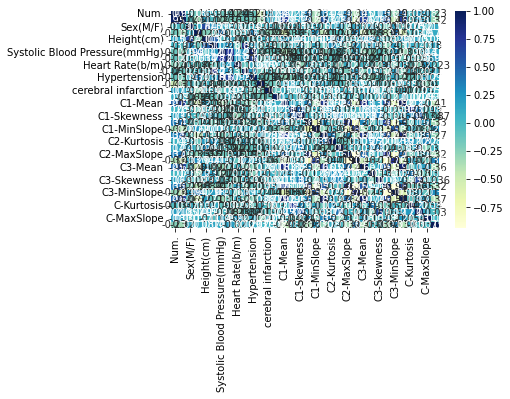

In [171]:
dataplot=sns.heatmap(SubjectData.corr(), cmap="YlGnBu", annot=True)
plt.show()

### Create Training and Test Sets

In [172]:
from sklearn.model_selection import train_test_split
# X = SubjectData.iloc[:, :-1]
X = SubjectData.drop([
    'subject_ID',
    'cerebral infarction',
    'C1-Mean','C1-Kurtosis','C1-Skewness','C1-MaxSlope','C1-MinSlope',
    'C2-Mean','C2-Kurtosis','C2-Skewness','C2-MaxSlope','C2-MinSlope',
    'C3-Mean','C3-Kurtosis','C3-Skewness','C3-MaxSlope','C3-MinSlope',
    ],axis=1)
y = SubjectData['cerebral infarction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [173]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
print('Using OverSampling to balance the dataset SMOTE: ')
print(f'Original dataset with cerebral infarction : {sum(y_train==1)}')
print(f'Original dataset without cerebral infarction : {sum(y_train==0)}')

smote = SMOTE(random_state = 2)
nearMiss = NearMiss()

X_train_over, y_train_over = smote.fit_resample(X_train, y_train.ravel())
X_train_miss, y_train_miss = nearMiss.fit_resample(X_train, y_train.ravel())


print(f'Over sampled dataset with cerebral infarction : {sum(y_train_over==1)}')
print(f'Over sampled dataset without cerebral infarction : {sum(y_train_over==0)}')
print()
print(f'Under sampled dataset with cerebral infarction : {sum(y_train_miss==1)}')
print(f'Under sampled dataset without cerebral infarction : {sum(y_train_miss==0)}')

Using OverSampling to balance the dataset SMOTE: 
Original dataset with cerebral infarction : 188
Original dataset without cerebral infarction : 20
Over sampled dataset with cerebral infarction : 188
Over sampled dataset without cerebral infarction : 188

Under sampled dataset with cerebral infarction : 20
Under sampled dataset without cerebral infarction : 20


## Building Models

### Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression
LogRegNormal = LogisticRegression()
LogRegOver = LogisticRegression()
LogRegUnder = LogisticRegression()
LogRegNormal.fit(X_train, y_train)
LogRegOver.fit(X_train_over, y_train_over)
LogRegUnder.fit(X_train_miss, y_train_miss)
print(f'Accuracy of Logistic regression classifier on training set: {LogRegNormal.score(X_train, y_train):.2f}')
print(f'Accuracy of Logistic regression classifier on test set: {LogRegNormal.score(X_test, y_test):.2f}')

print(f'Accuracy of Logistic regression classifier on over sampled training set: {LogRegOver.score(X_train_over, y_train_over):.2f}')
print(f'Accuracy of Logistic regression classifier on over sampled test set: {LogRegOver.score(X_test, y_test):.2f}')

print(f'Accuracy of Logistic regression classifier on under sampled training set: {LogRegUnder.score(X_train_miss, y_train_miss):.2f}')
print(f'Accuracy of Logistic regression classifier on under sampled test set: {LogRegUnder.score(X_test, y_test):.2f}')

Accuracy of Logistic regression classifier on training set: 0.90
Accuracy of Logistic regression classifier on test set: 1.00
Accuracy of Logistic regression classifier on over sampled training set: 0.81
Accuracy of Logistic regression classifier on over sampled test set: 0.64
Accuracy of Logistic regression classifier on under sampled training set: 0.78
Accuracy of Logistic regression classifier on under sampled test set: 0.27


c:\Users\Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### Decision Tree

In [175]:
from sklearn.tree import DecisionTreeClassifier
DTNormal = DecisionTreeClassifier().fit(X_train, y_train)
DTOver = DecisionTreeClassifier().fit(X_train_over, y_train_over)
DTUnder = DecisionTreeClassifier().fit(X_train_miss, y_train_miss)
print(f'Accuracy of Decision Tree classifier on training set: {DTNormal.score(X_train, y_train):.2f}')
print(f'Accuracy of Decision Tree classifier on test set: {DTNormal.score(X_test, y_test):.2f}')

print(f'Accuracy of Decision Tree classifier on over sampled training set: {DTOver.score(X_train_over, y_train_over):.2f}')
print(f'Accuracy of Decision Tree classifier on over sampled test set: {DTOver.score(X_test, y_test):.2f}')

print(f'Accuracy of Decision Tree classifier on under sampled training set: {DTUnder.score(X_train_miss, y_train_miss):.2f}')
print(f'Accuracy of Decision Tree classifier on under sampled test set: {DTUnder.score(X_test, y_test):.2f}')

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.82
Accuracy of Decision Tree classifier on over sampled training set: 1.00
Accuracy of Decision Tree classifier on over sampled test set: 1.00
Accuracy of Decision Tree classifier on under sampled training set: 1.00
Accuracy of Decision Tree classifier on under sampled test set: 0.82


### K Nearest Neighbours

In [176]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.92
Accuracy of K-NN classifier on test set: 0.91


### Support Vector Machine (SVM)

In [177]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.90
Accuracy of SVM classifier on test set: 1.00


In [178]:
y_pred = DTNormal.predict(X_test)


cm=Conf(y_test, y_pred)
print(cm)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

TN: 0
FP: 0
FN: 2
TP: 9
Precision: 1.0
Recall: 0.8181818181818182
F1 Score: 0.9
[[0, 0], [2, 9]]
[[0 0]
 [2 9]]
